In [1]:
# ================================================
# AMLS ECG Classification - Task 1.2 Baseline Model
# Model: STFT + 2D CNN + RNN + FC (PyTorch)
# ================================================

import numpy as np
import pandas as pd
import struct
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Settings
BATCH_SIZE = 64
EPOCHS = 50
EARLY_STOPPING = True
PATIENCE = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cuda')
print("Using device:", DEVICE)

Using device: cuda


In [2]:
# ==========================================
# 1. Data Loading - Reproducible Splits from Task 1.1
# ==========================================

import numpy as np
import pandas as pd
import struct

def load_bin_file(filepath):
    """Load ECG signals from .bin file."""
    signals = []
    with open(filepath, 'rb') as f:
        while True:
            length_bytes = f.read(4)
            if not length_bytes:
                break
            length = struct.unpack('i', length_bytes)[0]
            signal_bytes = f.read(length * 2)
            signal = np.frombuffer(signal_bytes, dtype=np.int16)
            signals.append(signal)
    return signals

# Load entire training & test datasets
X_train = load_bin_file('../1.1_dataset/data/X_train.bin')
y_train = pd.read_csv('../1.1_dataset/data/y_train.csv', header=None).iloc[:, 0].values
X_test = load_bin_file('../1.1_dataset/data/X_test.bin')

# Load split indices from Task 1.1 (REPRODUCIBLE SPLIT)
train_indices = np.load('../1.1_dataset/data/train_indices.npy')
val_indices = np.load('../1.1_dataset/data/val_indices.npy')
y_train_split = np.load('../1.1_dataset/data/y_train_split.npy')
y_val_split = np.load('../1.1_dataset/data/y_val_split.npy')

# Subset the signals using indices
X_train_split = [X_train[i] for i in train_indices]
X_val_split = [X_train[i] for i in val_indices]

print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")
print(f"Test samples: {len(X_test)}")


Training samples: 4943
Validation samples: 1236
Test samples: 2649


In [3]:
# ==========================================
# 2. Dataset & DataLoader
# ==========================================

class ECGDataset(Dataset):
    def __init__(self, signals, labels=None):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = torch.tensor(self.signals[idx], dtype=torch.float32)
        length = len(signal)
        if self.labels is not None:
            label = self.labels[idx]
            return signal, length, label
        else:
            return signal, length

def collate_fn_test(batch):
    signals, lengths = zip(*batch)
    signals = pad_sequence(signals, batch_first=True)
    lengths = torch.tensor(lengths)
    return signals, lengths
def collate_fn_train(batch):
    signals, lengths, labels = zip(*batch)
    signals = pad_sequence(signals, batch_first=True)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)
    return signals, lengths, labels


# Prepare DataLoaders
train_loader = DataLoader(
    ECGDataset(X_train_split, y_train_split),
    batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)

val_loader = DataLoader(
    ECGDataset(X_val_split, y_val_split),
    batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_train)


In [4]:
# ==========================================
# 3. Baseline Model (STFT → CNN → RNN → FC)
# ==========================================

class STFT_CNN_RNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_fft = 128
        self.hop_length = 16

        self.conv1 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2)
        )


        # Dummy forward pass to compute feature size
        dummy_signal = torch.randn(1, 3000)  # Simulate ~10-second ECG
        dummy_stft = torch.stft(dummy_signal, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        dummy_x = torch.abs(dummy_stft).log1p().unsqueeze(1)
        dummy_x = self.conv1(dummy_x)
        dummy_x = self.conv2(dummy_x)
        B, C, Freq, Time = dummy_x.size()
        feature_size = C * Freq

        self.rnn = nn.GRU(input_size=feature_size, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 4)

    def forward(self, x, lengths):
        stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        x = torch.abs(stft).log1p().unsqueeze(1)

        x = self.conv1(x)
        x = self.conv2(x)

        B, C, Freq, Time = x.size()
        x = x.view(B, C * Freq, Time).permute(0, 2, 1)

        lengths = torch.div(lengths, self.hop_length, rounding_mode='floor')
        lengths = lengths // 4
        lengths = torch.clamp(lengths, min=1, max=Time)

        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        output = self.fc(hidden[-1])
        return output


In [5]:
class ECG_1D_CNN_Enhanced(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        
        # Multi-scale feature extraction
        self.conv_blocks = nn.ModuleList([
            # Block 1: Capture fine-grained features (high-frequency noise, sharp peaks)
            nn.Sequential(
                nn.Conv1d(1, 32, kernel_size=7, padding=3),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(0.2)
            ),
            # Block 2: Capture QRS complex patterns
            nn.Sequential(
                nn.Conv1d(32, 64, kernel_size=11, padding=5),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(0.2)
            ),
            # Block 3: Capture broader cardiac cycle patterns
            nn.Sequential(
                nn.Conv1d(64, 128, kernel_size=15, padding=7),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(0.3)
            ),
            # Block 4: Capture long-term patterns
            nn.Sequential(
                nn.Conv1d(128, 256, kernel_size=21, padding=10),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),  # Global pooling regardless of input length
                nn.Dropout(0.4)
            )
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x, lengths=None):
        # Normalize input (important for ECG!)
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-8)
        
        # Add channel dimension
        x = x.unsqueeze(1)  # [batch, 1, sequence_length]
        
        # Pass through conv blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Flatten and classify
        x = x.squeeze(-1)  # Remove last dimension after global pooling
        x = self.classifier(x)
        
        return x

In [6]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Check your actual class distribution
print("Training class distribution:", Counter(y_train_split))

# Current weights are too weak - make them more aggressive
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_split), y=y_train_split)

# Boost minority classes even more
class_weights[1] *= 2.0  # Double Class 1 weight
class_weights[3] *= 3.0  # Triple Class 3 weight

print("Adjusted weights:", class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)


Training class distribution: Counter({np.int64(0): 2910, np.int64(2): 1412, np.int64(1): 439, np.int64(3): 182})
Adjusted weights: [ 0.42465636  5.62984055  0.87517705 20.36950549]


In [7]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Use this instead of CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = FocalLoss(alpha=1, gamma=2)

In [8]:

# Compute weights (outside the function, once)

# ==========================================
# 4. Training Utilities
# ==========================================

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for signals, lengths, labels in loader:
            signals, lengths = signals.to(DEVICE), lengths.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(signals, lengths)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average='macro')
    from collections import Counter
    print("Val Prediction Distribution:", Counter(y_pred))
    return f1


def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    model.to(DEVICE)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = FocalLoss(alpha=1, gamma=2)

    best_val_f1 = 0
    patience_counter = 0

    history = {'train_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for signals, lengths, labels in train_loader:
            signals, lengths, labels = signals.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(signals, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_f1 = evaluate(model, val_loader)
        scheduler.step(val_f1)

        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")

        history['train_loss'].append(avg_loss)
        history['val_f1'].append(val_f1)
        
        if EARLY_STOPPING:
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                patience_counter = 0
                # torch.save(model.state_dict(), 'best_model.pth')  # Save best model
                torch.save(model.state_dict(), 'stft_cnn_rnn_best.pth')
                print("✅ Model saved: best_model.pth")
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print("Early stopping.")
                    break


    return history

In [ ]:
# Training modifications for better results
def train_model_improved(model, train_loader, val_loader, epochs=50):
    # Lower learning rate for more stable training
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
    # Use label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for signals, lengths, labels in train_loader:
            signals, lengths, labels = signals.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(signals, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        val_f1 = evaluate(model, val_loader)
        
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")
        
        history['train_loss'].append(avg_loss)
        history['val_f1'].append(val_f1)
        
        # Learning rate scheduling
        scheduler.step(val_f1)
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping. Best Val F1: {best_val_f1:.4f}")
                break
    
    return history


🚀 Training ECG_1D_CNN_Enhanced...
Val Prediction Distribution: Counter({np.int64(0): 1230, np.int64(2): 6})
Epoch 1 - Loss: 0.5929, Val F1: 0.1882
✅ Model saved: best_model.pth
Val Prediction Distribution: Counter({np.int64(0): 1230, np.int64(2): 6})
Epoch 2 - Loss: 0.4651, Val F1: 0.1912
✅ Model saved: best_model.pth
Val Prediction Distribution: Counter({np.int64(0): 1141, np.int64(2): 94, np.int64(3): 1})
Epoch 3 - Loss: 0.4409, Val F1: 0.2590
✅ Model saved: best_model.pth
Val Prediction Distribution: Counter({np.int64(0): 1162, np.int64(2): 70, np.int64(3): 4})
Epoch 4 - Loss: 0.4190, Val F1: 0.2584
Val Prediction Distribution: Counter({np.int64(0): 1043, np.int64(2): 189, np.int64(3): 4})
Epoch 5 - Loss: 0.4087, Val F1: 0.2927
✅ Model saved: best_model.pth
Val Prediction Distribution: Counter({np.int64(0): 1039, np.int64(2): 186, np.int64(3): 11})
Epoch 6 - Loss: 0.3972, Val F1: 0.3479
✅ Model saved: best_model.pth
Val Prediction Distribution: Counter({np.int64(0): 824, np.int64(2

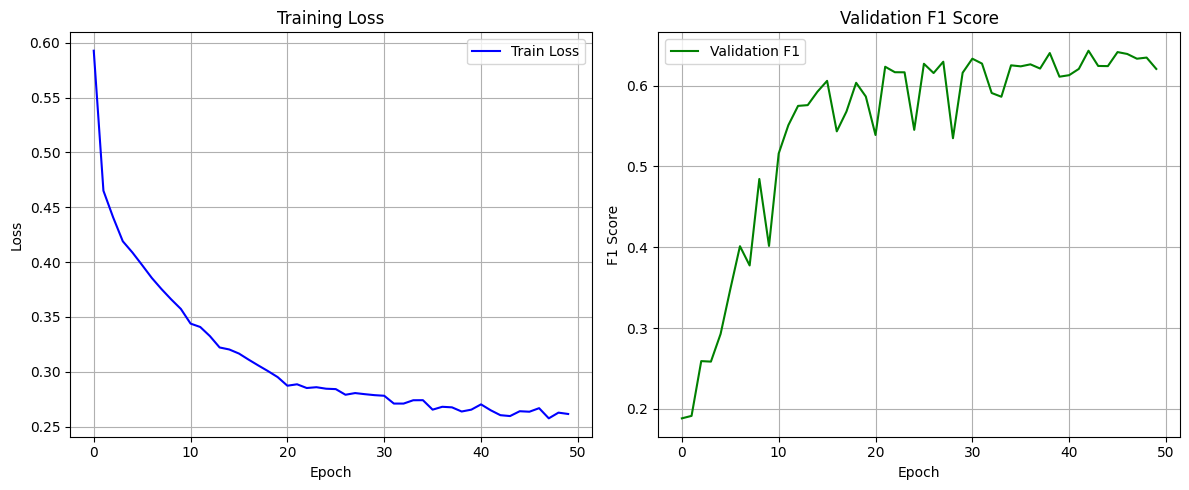


Final Results for ECG_1D_CNN_Enhanced:
Best Validation F1: 0.6433
Final Training Loss: 0.2614
Training completed in 50 epochs


In [ ]:
# ==========================================
# 5. Train Model (STFT_CNN_RNN_Model or ECG_1D_CNN_Enhanced)
# ==========================================

USE_STFT_MODEL = False  # ✅ Switch this flag between True (STFT) and False (1D CNN)

if USE_STFT_MODEL:
    model = STFT_CNN_RNN_Model().to(DEVICE)
    MODEL_NAME = "STFT_CNN_RNN_Model"
else:
    model = ECG_1D_CNN_Enhanced().to(DEVICE)
    MODEL_NAME = "ECG_1D_CNN_Enhanced"

print(f"\n🚀 Training {MODEL_NAME}...")

history = train_model(model, train_loader, val_loader)

# Save model weights
torch.save(model.state_dict(), f'{MODEL_NAME}.pth')
print(f"✅ Saved model weights to '{MODEL_NAME}.pth'")

# ==========================================
# 6. Plot Learning Curves
# ==========================================

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation F1 Score
plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Results for {MODEL_NAME}:")
print(f"Best Validation F1: {max(history['val_f1']):.4f}")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Training completed in {len(history['train_loss'])} epochs")


In [ ]:
# ==========================================
# 7. Inference on Test Data + Save Predictions
# ==========================================

MODEL_NAME = "ecg_1d_cnn"  # or "stft_cnn_rnn" depending on model used
MODEL_PATH = f"{MODEL_NAME}_best.pth"
PRED_PATH = f"{MODEL_NAME}_base.csv"

# Load correct model weights
model.load_state_dict(torch.load(MODEL_PATH))
print(f"✅ Loaded best saved model '{MODEL_PATH}' for final evaluation")

class TestECGDataset(Dataset):
    def __init__(self, signals):
        self.signals = signals

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = torch.tensor(self.signals[idx], dtype=torch.float32)
        length = len(signal)
        return signal, length

test_loader = DataLoader(
    TestECGDataset(X_test), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn_test
)

model.eval()
test_preds = []
with torch.no_grad():
    for signals, lengths in test_loader:
        signals, lengths = signals.to(DEVICE), lengths.to(DEVICE)
        if isinstance(model, ECG_1D_CNN_Enhanced):
            outputs = model(signals)
        else:
            outputs = model(signals, lengths)

        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())

# Save predictions to base.csv
df_preds = pd.DataFrame({'id': np.arange(len(test_preds)), 'class': test_preds})
df_preds.to_csv(PRED_PATH, index=False)

print(f"✅ Test predictions saved to '{PRED_PATH}'")


✅ Loaded best saved model for final evaluation
✅ Test predictions saved to base.csv


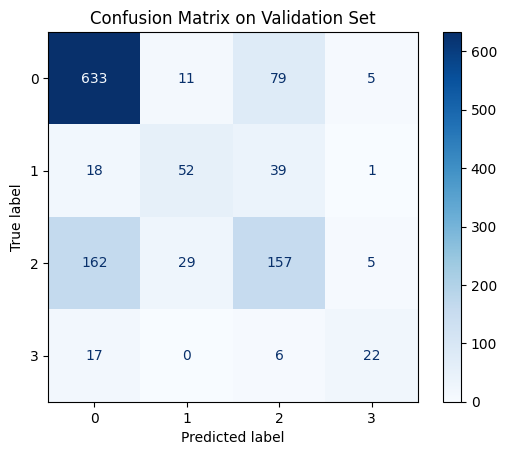

✅ Confusion matrix saved to 'confusion_matrix.png'


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, lengths, labels in val_loader:
        signals, lengths, labels = signals.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
        if isinstance(model, ECG_1D_CNN_Enhanced):
            outputs = model(signals)
        else:
            outputs = model(signals, lengths)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

print("✅ Confusion matrix saved to 'confusion_matrix.png'")



In [16]:
from sklearn.metrics import classification_report

# Collect predictions on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, lengths, labels in val_loader:
        signals, lengths, labels = signals.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
        if isinstance(model, ECG_1D_CNN_Enhanced):
            outputs = model(signals)
        else:
            outputs = model(signals, lengths)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
report = classification_report(y_true, y_pred, digits=3)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0      0.763     0.870     0.813       728
           1      0.565     0.473     0.515       110
           2      0.559     0.445     0.495       353
           3      0.667     0.489     0.564        45

    accuracy                          0.699      1236
   macro avg      0.638     0.569     0.597      1236
weighted avg      0.683     0.699     0.686      1236



In [ ]:
import pickle

# Save train/val/test splits (for reproducibility)
np.save('X_train_split.npy', np.array(train_indices))  # Indices only, to reuse original data
np.save('y_train_split.npy', y_train_split)
np.save('val_indices.npy', np.array(val_indices))
np.save('y_val_split.npy', y_val_split)

# Save class weights (for reuse in 1.3)
np.save('class_weights.npy', class_weights.cpu().numpy())
print("✅ Class weights saved to 'class_weights.npy'")

# Save training history
with open(f'{MODEL_NAME}_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print(f"✅ Training history saved to '{MODEL_NAME}_history.pkl'")

print("✅ All necessary files for Task 1.3 saved successfully.")


✅ Class weights saved to 'class_weights.npy'
✅ Training history saved to 'task1_2_history.pkl'
✅ All necessary files for Task 1.3 saved successfully.
